In [1]:
from neo4j import GraphDatabase

In [2]:
# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    print("Connection established.")

Connection established.


In [3]:
def run_query(query, params={}):
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        result = driver.execute_query(query, params)
        return result

# GraphSAGE Embeddings

First we need to build an in-memory projection representing the sub-graph on which we want to train our embedding model.
The projection includes all RATED predicates with a `rating` of 4 or higher. Therefore our projection consists of all user-RATED-book triples which can be described as a certain user liked a certain book.

Our goal is to construct graph embeddings which allow us to find books similar to a specified book, where "similar" means liked by similar users.
We also include the `RATED.rating` property in our projection. As GraphSAGE can use a numeric predicate property to place nodes with high property values closer together. 

In [4]:
create_user_liked_book_projection = """
MATCH (src:User)-[r:RATED]->(target:Book)
WHERE r.rating >= 4
RETURN gds.graph.project(
    "UserLikedBookProjection",
    src, 
    target,
    {
        sourceNodeLabels: labels(src),
        sourceNodeProperties: NULL,
        targetNodeLabels: labels(target),
        targetNodeProperties: target { .average_rating, .ratings_count, .work_ratings_count, .work_text_reviews_count, .ratings_1, .ratings_2,  .ratings_3,  .ratings_4,  .ratings_5  },
        relationshipType: type(r),
        relationshipProperties: r { .rating }
    }
)
"""

In [5]:
%%time
result = run_query(create_user_liked_book_projection)

CPU times: user 6.66 ms, sys: 939 μs, total: 7.6 ms
Wall time: 37.1 s


In [6]:
dict(result.records[0])

{'gds.graph.project(\n    "UserLikedBookProjection",\n    src, \n    target,\n    {\n        sourceNodeLabels: labels(src),\n        sourceNodeProperties: NULL,\n        targetNodeLabels: labels(target),\n        targetNodeProperties: target { .average_rating, .ratings_count, .work_ratings_count, .work_text_reviews_count, .ratings_1, .ratings_2,  .ratings_3,  .ratings_4,  .ratings_5  },\n        relationshipType: type(r),\n        relationshipProperties: r { .rating }\n    }\n)': {'relationshipCount': 4122111,
  'graphName': 'UserLikedBookProjection',
  'query': '\nMATCH (src:User)-[r:RATED]->(target:Book)\nWHERE r.rating >= 4\nRETURN gds.graph.project(\n    "UserLikedBookProjection",\n    src, \n    target,\n    {\n        sourceNodeLabels: labels(src),\n        sourceNodeProperties: NULL,\n        targetNodeLabels: labels(target),\n        targetNodeProperties: target { .average_rating, .ratings_count, .work_ratings_count, .work_text_reviews_count, .ratings_1, .ratings_2,  .ratings_3

In [7]:
inspect_graph_projection= """CALL gds.graph.list("UserLikedBookProjection")"""

In [8]:
result = run_query(inspect_graph_projection)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.list' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.list("UserLikedBookProjection")'


In [9]:
dict(result.records[0])

{'degreeDistribution': {'min': 0,
  'max': 194,
  'p90': 107,
  'p999': 166,
  'p99': 143,
  'p50': 70,
  'p75': 90,
  'p95': 119,
  'mean': 65.01137116361228},
 'graphName': 'UserLikedBookProjection',
 'database': 'neo4j',
 'databaseLocation': 'local',
 'memoryUsage': '48 MiB',
 'sizeInBytes': 50430576,
 'nodeCount': 63406,
 'relationshipCount': 4122111,
 'configuration': {'readConcurrency': 4,
  'undirectedRelationshipTypes': [],
  'jobId': 'a75f5354-034b-487b-b25b-3c788549bfe6',
  'logProgress': True,
  'query': '\nMATCH (src:User)-[r:RATED]->(target:Book)\nWHERE r.rating >= 4\nRETURN gds.graph.project(\n    "UserLikedBookProjection",\n    src, \n    target,\n    {\n        sourceNodeLabels: labels(src),\n        sourceNodeProperties: NULL,\n        targetNodeLabels: labels(target),\n        targetNodeProperties: target { .average_rating, .ratings_count, .work_ratings_count, .work_text_reviews_count, .ratings_1, .ratings_2,  .ratings_3,  .ratings_4,  .ratings_5  },\n        relation

In [11]:
# Delete the GraphSAGE model from the model cataloge if it was already trained previously

# result = run_query('CALL gds.model.drop("UserLikedBookModel")')

In [12]:
train_graphsage_embeddings_model = """
CALL gds.beta.graphSage.train(
    "UserLikedBookProjection",
    {
        modelName: "UserLikedBookModel",
        activationFunction: "ReLu",
        embeddingDimension: 64,
        aggregator: "Pool",
        featureProperties: [ "average_rating", "ratings_1", "ratings_2",  "ratings_3",  "ratings_4",  "ratings_5"  ],
        projectedFeatureDimension: 8,  // 2 labels + 6 properties
        batchSize: 300,
        relationshipWeightProperty: 'rating',
        maxIterations: 5,
        searchDepth: 2,
        epochs: 160,
        learningRate: 0.03,
        randomSeed: 42
    }
)
"""

In [13]:
%%time
result = run_query(train_graphsage_embeddings_model)

CPU times: user 9.25 ms, sys: 4.66 ms, total: 13.9 ms
Wall time: 7min 19s


We plot the loss per epoch:

Text(0, 0.5, 'Loss')

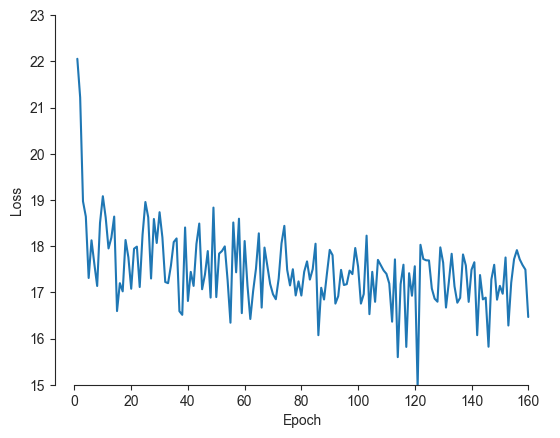

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")
ax= sns.lineplot(x=range(1,result.records[0][0]["metrics"]["ranEpochs"]+1), y=result.records[0][0]["metrics"]["epochLosses"])
ax.set_ylim(15, 23)
sns.despine(trim=True)
plt.xlabel("Epoch")
plt.ylabel("Loss")

We can add the embeddings calculated by our model back into our in-memory graph `UserLikedBookProjection`.

For this we first generate a new projection. This time one that includes all `User` and `Book` nodes, even those which might not have a single `RATED` relationship with a rating-property of 4 or higher.

In [15]:
create_user_book_projection = """
MATCH (src:User)-[r:RATED]->(target:Book)
RETURN gds.graph.project(
    "UserBookProjection",
    src, 
    target,
    {
        sourceNodeLabels: labels(src),
        sourceNodeProperties: NULL,
        targetNodeLabels: labels(target),
        targetNodeProperties: target { .average_rating, .ratings_count, .work_ratings_count, .work_text_reviews_count, .ratings_1, .ratings_2,  .ratings_3,  .ratings_4,  .ratings_5  },
        relationshipType: type(r),
        relationshipProperties: r { .rating }
    }
)
"""

In [16]:
%%time
result = run_query(create_user_book_projection)

CPU times: user 3.13 ms, sys: 3.79 ms, total: 6.92 ms
Wall time: 23.6 s


We then use `graphSage.write` to execute our previously trained model on the new projection and write back the resulting embeddings into our actual database graph as a new property for `User` and `Book` nodes named `GraphSageEmbedding`.

In [17]:
write_graphSage_embeddings_into_graph = """
CALL gds.beta.graphSage.write(
    "UserBookProjection",
    {
        modelName: "UserLikedBookModel",
        writeProperty: "GraphSageEmbedding"
    }
)
"""

In [18]:
%%time
result = run_query(write_graphSage_embeddings_into_graph)

CPU times: user 5.77 ms, sys: 0 ns, total: 5.77 ms
Wall time: 6.87 s


In [19]:
dict(result.records[0])

{'nodeCount': 63424,
 'nodePropertiesWritten': 63424,
 'preProcessingMillis': 28,
 'computeMillis': 4148,
 'writeMillis': 2475,
 'configuration': {'writeProperty': 'GraphSageEmbedding',
  'modelName': 'UserLikedBookModel',
  'jobId': 'b406c390-dbd1-454f-b28c-c20915425f25',
  'logProgress': True,
  'nodeLabels': ['*'],
  'relationshipTypes': ['*'],
  'concurrency': 4,
  'batchSize': 100,
  'sudo': False,
  'writeToResultStore': False,
  'writeConcurrency': 4}}

# FastRP embeddings

FastRP is another algorithm to calculate graph embeddings. However it can only operate on a mono-partite Graph, which means that the graph should only have 1 node type.

We can collapse our in-memory graph, so that we can build a sub-graph which only contains triples of the form "book"->predicate->"book".

For this we introduce a new relationship "LIKED_TOGETHER". In short we will collapse the graph so that book A liked by User U and a book B also liked by User U will be connected by a "LIKED_TOGETHER" edge. In short we will collapse the graph so that book nodes connected by a user node will be connected directly.

In [20]:
create_undirected_RATED_relationship = """
CALL gds.graph.relationships.toUndirected(
  'UserLikedBookProjection',
  {relationshipType: 'RATED', mutateRelationshipType: 'INTERACTS'}
)
"""

In [21]:
%%time
result = run_query(create_undirected_RATED_relationship)

CPU times: user 6.22 ms, sys: 0 ns, total: 6.22 ms
Wall time: 939 ms


In [22]:
dict(result.records[0])

{'inputRelationships': 4122111,
 'relationshipsWritten': 8244222,
 'mutateMillis': 0,
 'postProcessingMillis': 0,
 'preProcessingMillis': 1,
 'computeMillis': 840,
 'configuration': {'relationshipType': 'RATED',
  'jobId': 'a8d6c66b-7254-4c5b-9c07-0e98cac01e74',
  'logProgress': True,
  'concurrency': 4,
  'sudo': False,
  'mutateRelationshipType': 'INTERACTS'}}

In [23]:
create_monopartite_projection = """
CALL gds.collapsePath.mutate(
    "UserLikedBookProjection",
    {
        pathTemplates: [["INTERACTS", "INTERACTS"]],  // Connect Nodes which can be reached by traversing exactly two INTERACTS relationships
        allowSelfLoops: false,
        mutateRelationshipType: "LIKED_TOGETHER"
    }
)
"""

In [24]:
%%time
result = run_query(create_monopartite_projection)

CPU times: user 7.47 ms, sys: 423 μs, total: 7.89 ms
Wall time: 1min 23s


In [25]:
dict(result.records[0])

{'preProcessingMillis': 1,
 'computeMillis': 82961,
 'mutateMillis': 0,
 'relationshipsWritten': 2201131070,
 'configuration': {'jobId': '6ec037a7-8b23-4dd6-80eb-ecf84787185d',
  'logProgress': True,
  'pathTemplates': [['INTERACTS', 'INTERACTS']],
  'nodeLabels': ['*'],
  'relationshipTypes': ['*'],
  'concurrency': 4,
  'allowSelfLoops': False,
  'sudo': False,
  'mutateRelationshipType': 'LIKED_TOGETHER'}}

In [31]:
write_fastRP_embeddings = """
CALL gds.fastRP.write(
  'UserLikedBookProjection',
  {
    nodeLabels: ["Book"],
    relationshipTypes: ["LIKED_TOGETHER"],
    featureProperties: ["average_rating"],
    propertyRatio: 0.1,
    embeddingDimension: 64,
    writeProperty: 'FastRPEmbedding',
    randomSeed: 42
  }
)
"""

In [27]:
%%time
result = run_query(write_fastRP_embeddings)

CPU times: user 3.03 ms, sys: 4.34 ms, total: 7.38 ms
Wall time: 6.31 s


In [30]:
dict(result.records[0])

{'userID': 1,
 'u.GraphSageEmbedding': [-0.0006400768921880103,
  0.03949186780209071,
  -0.01537951665436493,
  -0.003094349954752823,
  -0.002175244019297649,
  0.526938001793839,
  -0.0010038711977323968,
  -0.0015490553456706374,
  -0.00738799524537254,
  0.026379587316462807,
  0.015155414999621314,
  -0.0019287100511406587,
  -0.013117054105921996,
  -0.0004498563749174485,
  -0.0024982234004825824,
  -0.0016805799692528609,
  0.4866184506887437,
  -0.005916970468893972,
  -0.010609253566027575,
  -0.010675220869345638,
  -0.0015089586240653063,
  -0.0005960872872248799,
  -0.0059940137973593256,
  -0.012615637092950585,
  -0.004010478695018206,
  -0.004744459971935296,
  -0.010988312061494063,
  0.3057899077918119,
  -0.0022144040474706837,
  -0.007329475981115031,
  0.01130224635323663,
  -0.0021614573109408077,
  -0.000285035099589326,
  -1.5776073823613153e-05,
  -0.0005851975626876736,
  -0.001903623114343038,
  0.23361603022643884,
  -0.0015453356494998583,
  -0.00102450194

# Sampling the generated Embeddings

In [32]:
import pandas as pd
result = run_query("MATCH (u:User) return u.user_id AS userID, u.GraphSageEmbedding LIMIT 3")
user_examples = pd.DataFrame(result.records, columns=result.keys)
user_examples

,userID,u.GraphSageEmbedding
0,1,"[-0.0006400768921880103, 0.03949186780209071, ..."
1,2,"[-0.0008057028957366731, -0.002561514378202998..."
2,4,"[-0.05573968682775346, -0.05138540736996429, -..."


In [33]:
import pandas as pd

result = run_query("MATCH (b:Book) return b.original_title AS origianlTitle, b.GraphSageEmbedding, b.FastRPEmbedding LIMIT 3")
book_examples = pd.DataFrame(result.records, columns=result.keys)
book_examples


,origianlTitle,b.GraphSageEmbedding,b.FastRPEmbedding
0,The Hunger Games,"[-0.0005426318486682, 0.21622100706339661, -0....","[0.0008753109141252935, -0.0007138390792533755..."
1,Harry Potter and the Philosopher's Stone,"[-0.0007853847234457214, 0.20743241505472532, ...","[0.0008753113215789199, -0.0007138386717997491..."
2,Twilight,"[0.223892453111938, 0.05092713920645491, -0.00...","[0.0008738047908991575, -0.0007121643284335732..."


# Using Embeddings to generate "SIMILAR_*" Relationships

As we used the `gds.*.write` function, the generated embeddings were written into our actual Neo4j database.
However we will use the `gds.knn` implementation to find the k-nearest neighbords of every node within our embedding space.
As with all other algorithms provided by `gds`, `gds.knn` can only operate on in-memory projections of neo4j graph.
Therefore we have to create a new projection, which contains our genrated embeddings.

In [34]:
create_user_book_embeddings_projection = """
MATCH (src:User)-[r:RATED]->(target:Book)
RETURN gds.graph.project(
    "UserBookEmbeddingsProjection",
    src, 
    target,
    {
        sourceNodeLabels: labels(src),
        sourceNodeProperties: src { .GraphSageEmbedding },
        targetNodeLabels: labels(target),
        targetNodeProperties: target { .GraphSageEmbedding, .FastRPEmbedding },
        relationshipType: type(r)
    }
)
"""

In [35]:
%%time
result = run_query(create_user_book_embeddings_projection)

CPU times: user 7.34 ms, sys: 0 ns, total: 7.34 ms
Wall time: 53.5 s


In [36]:
dict(result.records[0])

{'gds.graph.project(\n    "UserBookEmbeddingsProjection",\n    src, \n    target,\n    {\n        sourceNodeLabels: labels(src),\n        sourceNodeProperties: src { .GraphSageEmbedding },\n        targetNodeLabels: labels(target),\n        targetNodeProperties: target { .GraphSageEmbedding, .FastRPEmbedding },\n        relationshipType: type(r)\n    }\n)': {'relationshipCount': 5976479,
  'graphName': 'UserBookEmbeddingsProjection',
  'query': '\nMATCH (src:User)-[r:RATED]->(target:Book)\nRETURN gds.graph.project(\n    "UserBookEmbeddingsProjection",\n    src, \n    target,\n    {\n        sourceNodeLabels: labels(src),\n        sourceNodeProperties: src { .GraphSageEmbedding },\n        targetNodeLabels: labels(target),\n        targetNodeProperties: target { .GraphSageEmbedding, .FastRPEmbedding },\n        relationshipType: type(r)\n    }\n)\n',
  'projectMillis': 53346,
  'configuration': {'readConcurrency': 4,
   'undirectedRelationshipTypes': [],
   'jobId': '0b90b47e-d2aa-4dfd-

In [37]:
find_book_knn_graphsage = """
CALL gds.knn.filtered.write(
    "UserBookEmbeddingsProjection",
    {
        writeRelationshipType: "SIMILAR_GRAPHSAGE_EMBEDDING",
        writeProperty: "score",
        topK: 25,
        nodeProperties: [
            {GraphSageEmbedding: "COSINE"}
        ],
        sourceNodeFilter: "Book",
        targetNodeFilter: "Book"
    }
)
"""

In [38]:
%%time
result = run_query(find_book_knn_graphsage)

CPU times: user 3.4 ms, sys: 2.35 ms, total: 5.75 ms
Wall time: 28.4 s


In [39]:
dict(result.records[0])

{'ranIterations': 6,
 'didConverge': True,
 'nodePairsConsidered': 147573544,
 'preProcessingMillis': 0,
 'computeMillis': 19915,
 'writeMillis': 8416,
 'postProcessingMillis': 0,
 'nodesCompared': 63424,
 'relationshipsWritten': 250000,
 'similarityDistribution': {'min': 0.9990806579589844,
  'p5': 0.9999618530273438,
  'max': 0.9999999999999999,
  'p99': 0.9999961853027344,
  'p1': 0.9999122619628906,
  'p10': 0.9999771118164062,
  'p90': 0.9999961853027344,
  'p50': 0.9999961853027344,
  'p25': 0.9999923706054688,
  'p75': 0.9999961853027344,
  'p95': 0.9999961853027344,
  'mean': 0.9999900568084716,
  'p100': 0.9999961853027344,
  'stdDev': 1.8394500088319764e-05},
 'configuration': {'writeProperty': 'score',
  'writeRelationshipType': 'SIMILAR_GRAPHSAGE_EMBEDDING',
  'jobId': 'cb9cde69-4356-445f-b439-4fdd04658390',
  'deltaThreshold': 0.001,
  'topK': 25,
  'similarityCutoff': 0.0,
  'perturbationRate': 0.0,
  'sudo': False,
  'maxIterations': 100,
  'targetNodeFilter': 'NodeFilte

In [40]:
find_user_knn_graphsage = """
CALL gds.knn.filtered.write(
    "UserBookEmbeddingsProjection",
    {
        writeRelationshipType: "SIMILAR_GRAPHSAGE_EMBEDDING",
        writeProperty: "score",
        topK: 25,
        nodeProperties: [
            {GraphSageEmbedding: "COSINE"}
        ],
        sourceNodeFilter: "User",
        targetNodeFilter: "User"
    }
)
"""

In [41]:
%%time
result = run_query(find_user_knn_graphsage)

CPU times: user 4.39 ms, sys: 3.46 ms, total: 7.86 ms
Wall time: 1min 8s


In [42]:
dict(result.records[0])

{'ranIterations': 6,
 'didConverge': True,
 'nodePairsConsidered': 147503004,
 'preProcessingMillis': 0,
 'computeMillis': 35618,
 'writeMillis': 32975,
 'postProcessingMillis': 0,
 'nodesCompared': 63424,
 'relationshipsWritten': 1335600,
 'similarityDistribution': {'min': 0.8233375549316406,
  'p5': 0.9794960021972656,
  'max': 0.9999999999999999,
  'p99': 0.9998931884765625,
  'p1': 0.9590415954589844,
  'p10': 0.9868507385253906,
  'p90': 0.9995307922363281,
  'p50': 0.9979820251464844,
  'p25': 0.9943466186523438,
  'p75': 0.9990425109863281,
  'p95': 0.9997100830078125,
  'mean': 0.9948804206139815,
  'p100': 0.9999961853027344,
  'stdDev': 0.008198846226564369},
 'configuration': {'writeProperty': 'score',
  'writeRelationshipType': 'SIMILAR_GRAPHSAGE_EMBEDDING',
  'jobId': '37a294d0-683f-4b83-87e8-57c53e246f86',
  'deltaThreshold': 0.001,
  'topK': 25,
  'similarityCutoff': 0.0,
  'perturbationRate': 0.0,
  'sudo': False,
  'maxIterations': 100,
  'targetNodeFilter': 'NodeFilte

In [43]:
find_knn_fastrp = """
CALL gds.knn.write(
    "UserBookEmbeddingsProjection",
    {
        nodeLabels: ["Book"],
        writeRelationshipType: "SIMILAR_FASTRP_EMBEDDING",
        writeProperty: "score",
        topK: 25,
        nodeProperties: [
            {FastRPEmbedding: "COSINE"}
        ]
    }
)
"""

In [44]:
%%time
result = run_query(find_knn_fastrp)

CPU times: user 6.96 ms, sys: 0 ns, total: 6.96 ms
Wall time: 6.86 s


In [45]:
dict(result.records[0])

{'ranIterations': 2,
 'didConverge': True,
 'nodePairsConsidered': 10795338,
 'preProcessingMillis': 1,
 'computeMillis': 1386,
 'writeMillis': 5386,
 'postProcessingMillis': 0,
 'nodesCompared': 10000,
 'relationshipsWritten': 250000,
 'similarityDistribution': {'min': 0.9999961853027344,
  'p5': 1.0000038146972656,
  'max': 1.000007629394531,
  'p99': 1.0000038146972656,
  'p1': 1.0000038146972656,
  'p10': 1.0000038146972656,
  'p90': 1.0000038146972656,
  'p50': 1.0000038146972656,
  'p25': 1.0000038146972656,
  'p75': 1.0000038146972656,
  'p95': 1.0000038146972656,
  'mean': 1.0000038123474122,
  'p100': 1.0000038146972656,
  'stdDev': 1.3387470914927535e-07},
 'configuration': {'writeProperty': 'score',
  'writeRelationshipType': 'SIMILAR_FASTRP_EMBEDDING',
  'jobId': '08e4160e-3737-401e-bf0f-8a3d6e966dc5',
  'deltaThreshold': 0.001,
  'topK': 25,
  'similarityCutoff': 0.0,
  'perturbationRate': 0.0,
  'sudo': False,
  'maxIterations': 100,
  'writeToResultStore': False,
  'writ